In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import csv

import contractions
import nltk
from nltk.text import Text
from nltk.corpus import PlaintextCorpusReader
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import re 

In [2]:
df = pd.read_csv('washington_circuit.csv')

In [3]:
df

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe
0,https://twitter.com/nitababyx3/status/12560071...,2020-04-30 23:46:43+00:00,hahahahah see covid,hahahahah see covid,1256007102948151302,https://twitter.com/nitababyx3,0,0,0,0,...,1.256004e+18,https://twitter.com/sobihawk,"[User(username='0konkwo', id=14273216924062883...","Coordinates(longitude=-77.252481, latitude=38....","Place(id='01c8b21330402f48', fullName='Newingt...",NaN,NaN,NaN,NaN,NaN
1,https://twitter.com/atrupar/status/12560014221...,2020-04-30 23:24:09+00:00,astounding many people like brian kilmeade amp...,astounding many people like brian kilmeade amp...,1256001422132420611,https://twitter.com/atrupar,111,377,1478,16,...,NaN,NaN,NaN,"Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...",NaN,NaN,NaN,NaN,NaN
2,https://twitter.com/NichelleBorden/status/1255...,2020-04-30 23:17:56+00:00,diddy make think much power hold whole ethnici...,diddy make think much power hold whole ethnici...,1255999859896844288,https://twitter.com/NichelleBorden,0,0,0,0,...,NaN,NaN,"[User(username='Diddy', id=18220175, displayna...","Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...","['StopTheDumbStuff', 'Biden2020', 'BlackPeople...",NaN,NaN,NaN,NaN
3,https://twitter.com/nitababyx3/status/12559998...,2020-04-30 23:17:50+00:00,covid something new pick line huh good love,covid something new pick line huh good love,1255999835460833282,https://twitter.com/nitababyx3,2,0,8,1,...,NaN,NaN,NaN,"Coordinates(longitude=-77.252481, latitude=38....","Place(id='01c8b21330402f48', fullName='Newingt...",NaN,NaN,NaN,NaN,NaN
4,https://twitter.com/andfogle/status/1255995213...,2020-04-30 22:59:28+00:00,month old want think comparatively prison poli...,month old want think comparatively prison poli...,1255995213644009473,https://twitter.com/andfogle,2,0,0,0,...,1.255992e+18,https://twitter.com/Sadeq008,"[User(username='Sadeq008', id=197402758, displ...","Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12242,https://twitter.com/HarlemGirl59/status/124151...,2020-03-22 00:11:24+00:00,watch footprint coronavirus spread across coun...,watch footprint coronavirus spread across country,1241517801665261568,https://twitter.com/HarlemGirl59,0,0,0,0,...,NaN,NaN,NaN,"Coordinates(longitude=-76.800034, latitude=38....","Place(id='369842624da7239c', fullName='Bowie, ...",NaN,NaN,NaN,NaN,NaN
12243,https://twitter.com/HarlemGirl59/status/124151...,2020-03-22 00:08:34+00:00,coronavirus halt street protest climate activi...,coronavirus halt street protest climate activi...,1241517088352714754,https://twitter.com/HarlemGirl59,0,0,0,0,...,NaN,NaN,NaN,"Coordinates(longitude=-76.800034, latitude=38....","Place(id='369842624da7239c', fullName='Bowie, ...",NaN,NaN,NaN,NaN,NaN
12244,https://twitter.com/HarlemGirl59/status/124151...,2020-03-22 00:08:18+00:00,coronavirus crisis may hinder effort fight wil...,coronavirus crisis may hinder effort fight wil...,1241517019327090689,https://twitter.com/HarlemGirl59,0,0,0,0,...,NaN,NaN,NaN,"Coordinates(longitude=-76.800034, latitude=38....","Place(id='369842624da7239c', fullName='Bowie, ...",NaN,NaN,NaN,NaN,NaN
12245,https://twitter.com/stranahan/status/124151542...,2020-03-22 00:01:57+00:00,child handling coronavirus crisis unprecedente...,child handling coronavirus crisis unprecedente...,1241515421125300226,https://twitter.com/stranahan,24,4,12,2,...,NaN,NaN,NaN,"Coordinates(longitude=-77.144435, latitude=38....","Place(id='d6819fe60643ebc1', fullName='Alexand...",NaN,NaN,NaN,NaN,NaN


In [4]:
df.isna().sum()

url                     0
date                    0
rawContent              5
renderedContent         5
id                      0
user                    0
replyCount              0
retweetCount            0
likeCount               0
quoteCount              0
conversationId          0
lang                    0
source                  0
sourceUrl               0
sourceLabel             0
links                7794
media               10115
retweetedTweet      12247
quotedTweet         10438
inReplyToTweetId    10386
inReplyToUser       10386
mentionedUsers       7399
coordinates             3
place                   0
hashtags             6328
cashtags            12245
card                10731
viewCount           12247
vibe                12247
dtype: int64

In [3]:
df['rawContent'].fillna('', inplace=True)
df['renderedContent'].fillna('', inplace=True)

In [4]:
## remove specific word HTTP
df['rawContent'] = df['rawContent'].str.replace('covid', '')
df['rawContent'] = df['rawContent'].str.replace('coronavirus', '')

df['renderedContent'] = df['renderedContent'].str.replace('covid', '')
df['renderedContent'] = df['renderedContent'].str.replace('coronavirus', '')

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 10)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

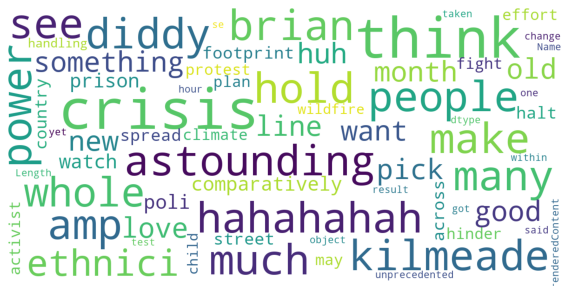

In [8]:
show_wordcloud(df["renderedContent"])

In [5]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [6]:
data = df['renderedContent'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['hahahahah', 'see']


## Building Bi-gram and Tri-gram Models

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [8]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [13]:
data_words_bigrams = make_bigrams(data_words)
data_words_bigrams

[['hahahahah', 'see'],
 ['astounding',
  'many',
  'people',
  'like',
  'brian',
  'kilmeade',
  'amp',
  'get',
  'communicable',
  'disease',
  'work',
  'still',
  'get',
  'even',
  'go',
  'crowded',
  'beach',
  'virus',
  'spread',
  'person',
  'person',
  'basic',
  'amp',
  'many',
  'people',
  'clueless'],
 ['diddy',
  'make',
  'think',
  'much',
  'power',
  'hold',
  'whole',
  'ethnicity',
  'people',
  'blackpeoplevote',
  'trumpisdone',
  'saveourselves',
  'kennyburns',
  'joebiden',
  'teamjoe',
  'bet'],
 ['something', 'new', 'pick', 'line', 'huh', 'good', 'love'],
 ['month',
  'old',
  'want',
  'think',
  'comparatively',
  'prison',
  'policy',
  'rolling',
  'update',
  'response',
  'prison',
  'hope',
  'day',
  'come',
  'soon',
  'iranian',
  'kind',
  'work',
  'inside',
  'country',
  'without',
  'getting',
  'bullied'],
 ['minute',
  'annlive',
  'maintain',
  'healthy',
  'relationship',
  'staying',
  'home',
  'husband',
  'kid',
  'family',
  'frie

In [9]:
data_words_trigrams = make_trigrams(data_words)
data_words_trigrams

[['hahahahah', 'see'],
 ['astounding',
  'many',
  'people',
  'like',
  'brian',
  'kilmeade',
  'amp',
  'get',
  'communicable',
  'disease',
  'work',
  'still',
  'get',
  'even',
  'go',
  'crowded',
  'beach',
  'virus',
  'spread',
  'person',
  'person',
  'basic',
  'amp',
  'many',
  'people',
  'clueless'],
 ['diddy',
  'make',
  'think',
  'much',
  'power',
  'hold',
  'whole',
  'ethnicity',
  'people',
  'blackpeoplevote',
  'trumpisdone',
  'saveourselves',
  'kennyburns',
  'joebiden',
  'teamjoe',
  'bet'],
 ['something', 'new', 'pick', 'line', 'huh', 'good', 'love'],
 ['month',
  'old',
  'want',
  'think',
  'comparatively',
  'prison',
  'policy',
  'rolling',
  'update',
  'response',
  'prison',
  'hope',
  'day',
  'come',
  'soon',
  'iranian',
  'kind',
  'work',
  'inside',
  'country',
  'without',
  'getting',
  'bullied'],
 ['minute',
  'annlive',
  'maintain',
  'healthy',
  'relationship',
  'staying_home',
  'husband',
  'kid',
  'family',
  'friend'],

## Building rough LDA model 

In [10]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words_trigrams)

# Create Corpus
texts = data_words_trigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1)]


In [16]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [17]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"amp" + 0.006*"like" + 0.006*"trump" + 0.006*"say" + 0.006*"people" + '
  '0.005*"need" + 0.004*"get" + 0.004*"worker" + 0.004*"thing" + 0.004*"food"'),
 (1,
  '0.014*"people" + 0.009*"get" + 0.006*"pandemic" + 0.006*"time" + '
  '0.005*"american" + 0.005*"one" + 0.005*"day" + 0.004*"say" + '
  '0.004*"quarantine" + 0.004*"test"'),
 (2,
  '0.015*"case" + 0.012*"death" + 0.012*"amp" + 0.007*"dc" + 0.006*"maryland" '
  '+ 0.005*"new" + 0.005*"day" + 0.005*"time" + 0.005*"number" + '
  '0.005*"health"'),
 (3,
  '0.013*"amp" + 0.006*"help" + 0.006*"support" + 0.006*"pandemic" + '
  '0.005*"community" + 0.005*"time" + 0.005*"join" + 0.005*"crisis" + '
  '0.004*"family" + 0.004*"dc"'),
 (4,
  '0.025*"trump" + 0.009*"say" + 0.009*"people" + 0.008*"pandemic" + '
  '0.007*"like" + 0.007*"president" + 0.006*"realdonaldtrump" + 0.006*"would" '
  '+ 0.005*"response" + 0.004*"virus"')]


In [18]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.25421408924080796


## Tuning based on number of topics

In [19]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
       
    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    # Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, 
                                         coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [20]:
# Can take a long time to run. In this case we are going to k_max=14.
import datetime
print(datetime.datetime.now())

from gensim.models import CoherenceModel

coherence_scores = []
model_topics = []

for k in range(2, 20):
    cv = compute_coherence_values(corpus=corpus, dictionary=id2word,k=k) 
    model_topics.append(k)    
    coherence_scores.append(cv)    
    print("#Topics: " + str(k) + ", Score: " + str(coherence_scores[-1]))

print(datetime.datetime.now())

2023-03-12 02:32:17.603422
#Topics: 2, Score: 0.12373941651972262
#Topics: 3, Score: 0.17369707154953182
#Topics: 4, Score: 0.20786610922996968
#Topics: 5, Score: 0.24533097743284307
#Topics: 6, Score: 0.26070271797162115
#Topics: 7, Score: 0.2987329940062822
#Topics: 8, Score: 0.3144608746404733
#Topics: 9, Score: 0.3102097025214879
#Topics: 10, Score: 0.3143491000344911
#Topics: 11, Score: 0.39554085412460194
#Topics: 12, Score: 0.35345878041601536
#Topics: 13, Score: 0.31748799540742306
#Topics: 14, Score: 0.3463998098966555
#Topics: 15, Score: 0.36616145301570174
#Topics: 16, Score: 0.3595272181528679
#Topics: 17, Score: 0.3646872361796571
#Topics: 18, Score: 0.3645785789738001
#Topics: 19, Score: 0.37469919223277753
2023-03-12 02:39:40.079754


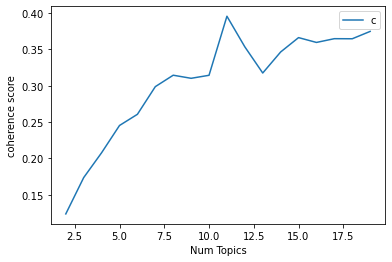

In [21]:
# Show graph

import matplotlib.pyplot as plt

limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence score"), loc='best')
plt.show()

In [22]:
end here

SyntaxError: invalid syntax (<ipython-input-22-9bcc9ab561c7>, line 1)

### Final Model

In [11]:
num_topics = 11

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)

In [12]:
# Save the LDA model

from gensim.test.utils import datapath

lda_model_saved_file = datapath("us_circuit_lda_model_11")
lda_model.save(lda_model_saved_file)

In [24]:
score = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
score.get_coherence()

0.38401742727794924

In [25]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./lda_model/washington_circuit_lda_vis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './lda_vis/washington_circuit_lda_vis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.151747  0.002420       1        1  21.154651
4     -0.205544 -0.026714       2        1  13.458172
2     -0.104285  0.137139       3        1  12.367323
8      0.061917  0.179437       4        1   7.765270
3      0.044765  0.115197       5        1   7.758914
1     -0.065325 -0.156735       6        1   7.639515
0     -0.063275 -0.042948       7        1   6.881562
5      0.102916 -0.037562       8        1   6.584047
10     0.065949  0.006053       9        1   5.986064
6      0.208242  0.021357      10        1   5.368814
9      0.106387 -0.197643      11        1   5.035667, topic_info=        Term         Freq        Total Category  logprob  loglift
142    trump  1310.000000  1310.000000  Default  30.0000  30.0000
126     case   505.000000   505.000000  Default  29.0000  29.0000
17    people  1163.000000  1163.000000  Default  28.0000  28.0000
285    death   535.000000   535.000000  Default  27.0000  27.0000
83       say   790.000000   790.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
12       get    57.974879   699.036544  Topic11  -4.9118   0.4989
35     think    46.698637   323.234085  Topic11  -5.1281   1.0540
993     home    36.940856   274.871840  Topic11  -5.3625   0.9816
1528     age    33.767037    91.626508  Topic11  -5.4523   1.9904
1230    hard    32.596493   124.218075  Topic11  -5.4876   1.6508

[671 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4315      1  0.987469  absolutely
2991      1  0.108106    accurate
2991      7  0.864845    accurate
2377     11  0.963302    activist
1517      9  0.983891         add
...     ...       ...         ...
236       8  0.037186        year
236      11  0.004648        year
2493      8  0.124827       young
2493     11  0.842584       young
3610     11  0.986572        zoom

[1375 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 3, 9, 4, 2, 1, 6, 11, 7, 10])

**Added Sentiment Analysis**

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [12]:
def determine_sentiment(score):
    if score < 0:
        return "Negative"
    elif score > 0:
        return "Positive"
    else:
        return "Neutral"

In [13]:
df["renderedContent"] = df['renderedContent'].apply(lambda tweet:str(tweet))
sentiment_scores = df['renderedContent'].apply(sid.polarity_scores)
sentiment_scores

0        {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1        {'neg': 0.081, 'neu': 0.747, 'pos': 0.172, 'co...
2        {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3        {'neg': 0.0, 'neu': 0.413, 'pos': 0.587, 'comp...
4        {'neg': 0.191, 'neu': 0.493, 'pos': 0.316, 'co...
                               ...                        
12242    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
12243    {'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'comp...
12244    {'neg': 0.626, 'neu': 0.374, 'pos': 0.0, 'comp...
12245    {'neg': 0.255, 'neu': 0.745, 'pos': 0.0, 'comp...
12246    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: renderedContent, Length: 12247, dtype: object

In [14]:
# Load the saved model

from gensim.test.utils import datapath
lda_model_saved_file = datapath("us_circuit_lda_model_11")
lda_model = gensim.models.ldamodel.LdaModel.load(lda_model_saved_file)

In [15]:
topics, num_topics = [], 11

for i in range(len(corpus)):
    top_topics = (
        lda_model.get_document_topics(corpus[i],
                                      minimum_probability=0.0))
    topic_vec = [top_topics[i][1] for i in range(num_topics)]
    topics.append(topic_vec.index(max(topic_vec))+1)
    
topics

[8,
 1,
 11,
 6,
 7,
 5,
 9,
 4,
 10,
 7,
 5,
 3,
 9,
 7,
 1,
 3,
 8,
 7,
 7,
 4,
 7,
 5,
 8,
 4,
 8,
 8,
 2,
 8,
 11,
 10,
 4,
 8,
 10,
 8,
 9,
 9,
 5,
 5,
 9,
 2,
 2,
 9,
 11,
 10,
 1,
 5,
 3,
 3,
 3,
 4,
 5,
 7,
 10,
 1,
 8,
 5,
 5,
 9,
 4,
 3,
 4,
 5,
 5,
 3,
 1,
 11,
 7,
 6,
 9,
 9,
 5,
 7,
 4,
 10,
 1,
 1,
 4,
 1,
 8,
 11,
 4,
 9,
 2,
 5,
 6,
 7,
 2,
 2,
 3,
 2,
 10,
 9,
 4,
 7,
 1,
 5,
 6,
 10,
 4,
 7,
 10,
 7,
 8,
 2,
 8,
 1,
 8,
 1,
 5,
 1,
 7,
 8,
 9,
 8,
 7,
 3,
 10,
 10,
 6,
 8,
 6,
 4,
 7,
 9,
 4,
 3,
 7,
 1,
 1,
 10,
 7,
 6,
 5,
 9,
 5,
 11,
 1,
 10,
 8,
 10,
 11,
 11,
 6,
 10,
 7,
 2,
 11,
 10,
 1,
 2,
 7,
 2,
 2,
 1,
 4,
 8,
 1,
 1,
 4,
 5,
 9,
 5,
 4,
 6,
 2,
 7,
 8,
 7,
 10,
 2,
 5,
 9,
 7,
 2,
 1,
 1,
 11,
 7,
 7,
 7,
 7,
 5,
 7,
 2,
 4,
 11,
 8,
 4,
 6,
 4,
 5,
 8,
 2,
 8,
 8,
 5,
 7,
 8,
 7,
 10,
 7,
 1,
 1,
 2,
 9,
 8,
 11,
 9,
 3,
 2,
 11,
 7,
 7,
 2,
 11,
 3,
 9,
 7,
 6,
 5,
 7,
 2,
 2,
 2,
 8,
 6,
 2,
 4,
 6,
 10,
 10,
 6,
 2,
 11,
 5,
 11,
 8,
 2,
 8,
 2,
 9,


In [16]:
df["Topic"] = topics
df.head()

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe,Topic
0,https://twitter.com/nitababyx3/status/12560071...,2020-04-30 23:46:43+00:00,hahahahah see,hahahahah see,1256007102948151302,https://twitter.com/nitababyx3,0,0,0,0,...,https://twitter.com/sobihawk,"[User(username='0konkwo', id=14273216924062883...","Coordinates(longitude=-77.252481, latitude=38....","Place(id='01c8b21330402f48', fullName='Newingt...",NaN,NaN,NaN,NaN,NaN,8
1,https://twitter.com/atrupar/status/12560014221...,2020-04-30 23:24:09+00:00,astounding many people like brian kilmeade amp...,astounding many people like brian kilmeade amp...,1256001422132420611,https://twitter.com/atrupar,111,377,1478,16,...,NaN,NaN,"Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...",NaN,NaN,NaN,NaN,NaN,1
2,https://twitter.com/NichelleBorden/status/1255...,2020-04-30 23:17:56+00:00,diddy make think much power hold whole ethnici...,diddy make think much power hold whole ethnici...,1255999859896844288,https://twitter.com/NichelleBorden,0,0,0,0,...,NaN,"[User(username='Diddy', id=18220175, displayna...","Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...","['StopTheDumbStuff', 'Biden2020', 'BlackPeople...",NaN,NaN,NaN,NaN,11
3,https://twitter.com/nitababyx3/status/12559998...,2020-04-30 23:17:50+00:00,something new pick line huh good love,something new pick line huh good love,1255999835460833282,https://twitter.com/nitababyx3,2,0,8,1,...,NaN,NaN,"Coordinates(longitude=-77.252481, latitude=38....","Place(id='01c8b21330402f48', fullName='Newingt...",NaN,NaN,NaN,NaN,NaN,6
4,https://twitter.com/andfogle/status/1255995213...,2020-04-30 22:59:28+00:00,month old want think comparatively prison poli...,month old want think comparatively prison poli...,1255995213644009473,https://twitter.com/andfogle,2,0,0,0,...,https://twitter.com/Sadeq008,"[User(username='Sadeq008', id=197402758, displ...","Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...",NaN,NaN,NaN,NaN,NaN,7


In [17]:
sentiments = sentiment_scores.apply(lambda x: x["compound"])
sentiment_label = sentiments.apply(determine_sentiment)
df["Sentiment"] = sentiment_label
df.head()

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe,Topic,Sentiment
0,https://twitter.com/nitababyx3/status/12560071...,2020-04-30 23:46:43+00:00,hahahahah see,hahahahah see,1256007102948151302,https://twitter.com/nitababyx3,0,0,0,0,...,"[User(username='0konkwo', id=14273216924062883...","Coordinates(longitude=-77.252481, latitude=38....","Place(id='01c8b21330402f48', fullName='Newingt...",NaN,NaN,NaN,NaN,NaN,8,Neutral
1,https://twitter.com/atrupar/status/12560014221...,2020-04-30 23:24:09+00:00,astounding many people like brian kilmeade amp...,astounding many people like brian kilmeade amp...,1256001422132420611,https://twitter.com/atrupar,111,377,1478,16,...,NaN,"Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...",NaN,NaN,NaN,NaN,NaN,1,Positive
2,https://twitter.com/NichelleBorden/status/1255...,2020-04-30 23:17:56+00:00,diddy make think much power hold whole ethnici...,diddy make think much power hold whole ethnici...,1255999859896844288,https://twitter.com/NichelleBorden,0,0,0,0,...,"[User(username='Diddy', id=18220175, displayna...","Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...","['StopTheDumbStuff', 'Biden2020', 'BlackPeople...",NaN,NaN,NaN,NaN,11,Neutral
3,https://twitter.com/nitababyx3/status/12559998...,2020-04-30 23:17:50+00:00,something new pick line huh good love,something new pick line huh good love,1255999835460833282,https://twitter.com/nitababyx3,2,0,8,1,...,NaN,"Coordinates(longitude=-77.252481, latitude=38....","Place(id='01c8b21330402f48', fullName='Newingt...",NaN,NaN,NaN,NaN,NaN,6,Positive
4,https://twitter.com/andfogle/status/1255995213...,2020-04-30 22:59:28+00:00,month old want think comparatively prison poli...,month old want think comparatively prison poli...,1255995213644009473,https://twitter.com/andfogle,2,0,0,0,...,"[User(username='Sadeq008', id=197402758, displ...","Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...",NaN,NaN,NaN,NaN,NaN,7,Positive


In [18]:
for content in df[(df["Topic"] == 8) & (df["Sentiment"] == "Positive")].renderedContent:
    print(content)

jaredkushner let get straight others suppose put trust situation zero medical experience especially hear talked nothing president taking  seriously
many healthcare worker frontline need mental health support month even year get crisis consider donating lorna breen hero fund
u china democrat republican affect specie know single person want save many life possible get back normal life soon aslavitt right amp must unite beat  peteforamerica 
prsasw prssanational prsa honestly would fly prsa nest far better prsa fresh new grad fresh idea post  world keep prsa mind change start fly free bet go much farther
delayed event admins dc water denied gift hope bless today started delivering come back gift
today turning annual day giving day giving back help spj creating emergency fund aid journalist need financial support pandemic join u thanks spjgivesback
leannapearce good news korea discovered negative testing patient recovered antibody developed successfully defended reinfection encouraging  an

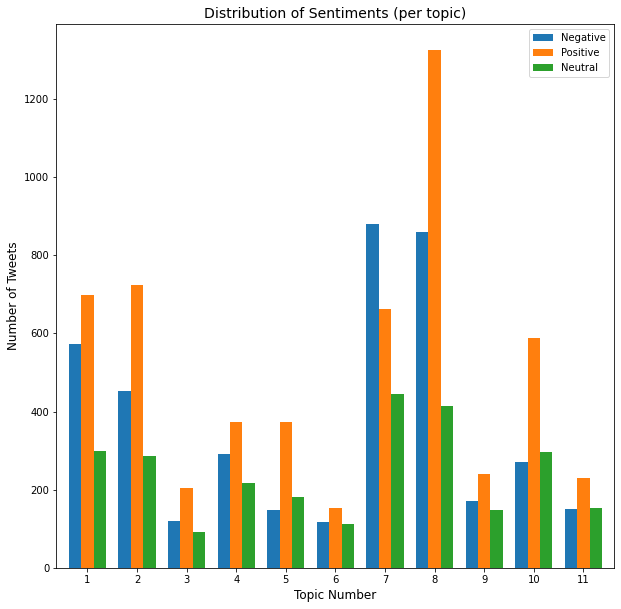

In [19]:
import matplotlib.pyplot as plt

topics = range(1, num_topics+1)
columns = ["Negative", "Positive", "Neutral"]
data = []

for i in range(num_topics):
    curr_topic = df[df["Topic"] == i+1]
    negative, positive, neutral = len(curr_topic[curr_topic["Sentiment"] == "Negative"]), len(curr_topic[curr_topic["Sentiment"] == "Positive"]), len(curr_topic[curr_topic["Sentiment"] == "Neutral"]) 
    data.append([negative, positive, neutral])

topic_sentiment_df = pd.DataFrame(data, columns=columns, index=topics)
topic_sentiment_df.plot(kind="bar", figsize=(10, 10), width=0.75)
plt.title("Distribution of Sentiments (per topic)", fontsize=14)
plt.xlabel("Topic Number", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.gca().xaxis.set_tick_params(rotation=0)
plt.show()